In [46]:
import numpy as np
import os
import service.globals as _g

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [47]:
# define base data, label store path
old_data_path = os.path.abspath(_g.OLD_DATA_FOLDER_NAME)
new_data_path = os.path.abspath(_g.NEW_DATA_FOLDER_NAME)
old_label_path = os.path.join(old_data_path, _g.LABEL_NAME)
new_label_path = os.path.join(new_data_path, _g.LABEL_NAME)

In [48]:
with open(f'{old_data_path}/labels.txt', 'r') as f:
    lines = f.readlines()
    # actions = [line.strip().split()[0] for line in lines]
    # labels = [line.strip().split()[1] for line in lines]
    actions, labels = zip(*[line.strip().split() for line in lines])

# 라벨 추가 작업 수행
gesture_data = []
for action, label in zip(actions, labels):
    seq_data = np.load(f'{old_data_path}/seq_{action}.npy')
    label_data = np.full((seq_data.shape[0], seq_data.shape[1], 1), label) # 라벨 추가
    data_with_label = np.concatenate([seq_data, label_data], axis=-1) # 라벨 추가된 데이터
    gesture_data.append(data_with_label)

data = np.concatenate(gesture_data, axis=0)
data.shape

(2060, 30, 78)

In [49]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

x_data.shape, labels.shape

((2060, 30, 77), (2060,))

In [50]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2060, 5)

In [51]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022)

x_train.shape, y_train.shape

((1854, 30, 77), (1854, 5))

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
model = Sequential([
    GRU(64, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(16, activation='tanh'),
    Dropout(0.5),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                27456     
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 85        
                                                                 
Total params: 28,581
Trainable params: 28,581
Non-trainable params: 0
_________________________________________________________________


In [53]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the callbacks
callbacks = [
    ModelCheckpoint('models/base_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=30, verbose=1, mode='auto'),
]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/100
24/29 [=======================>......] - ETA: 0s - loss: 1.3468 - acc: 0.4355
Epoch 1: val_acc improved from -inf to 0.94660, saving model to models\base_model.h5
29/29 [==============================] - 2s 19ms/step - loss: 1.2734 - acc: 0.4703 - val_loss: 0.7405 - val_acc: 0.9466 - lr: 0.0010
Epoch 2/100
23/29 [======================>.......] - ETA: 0s - loss: 0.7193 - acc: 0.7942
Epoch 2: val_acc improved from 0.94660 to 0.99515, saving model to models\base_model.h5
29/29 [==============================] - 0s 9ms/step - loss: 0.6861 - acc: 0.8058 - val_loss: 0.4178 - val_acc: 0.9951 - lr: 0.0010
Epoch 3/100
23/29 [======================>.......] - ETA: 0s - loss: 0.4481 - acc: 0.9226
Epoch 3: val_acc improved from 0.99515 to 1.00000, saving model to models\base_model.h5
29/29 [==============================] - 0s 9ms/step - loss: 0.4318 - acc: 0.9293 - val_loss: 0.2100 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/100
29/29 [==============================] - ETA: 0s - loss: 0.2

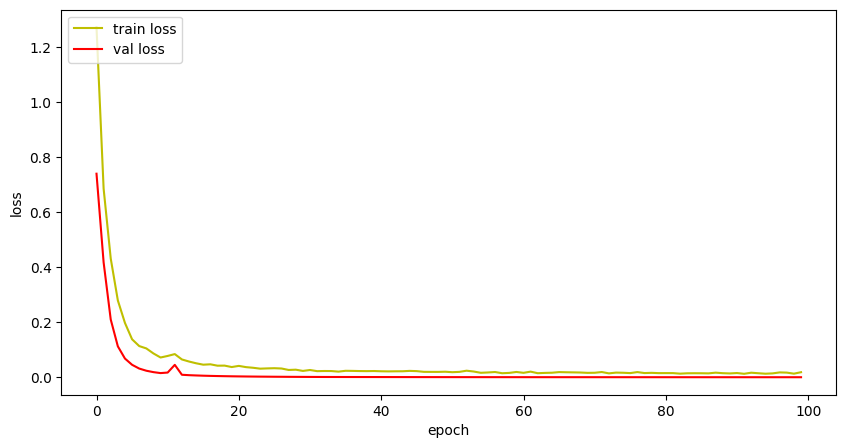

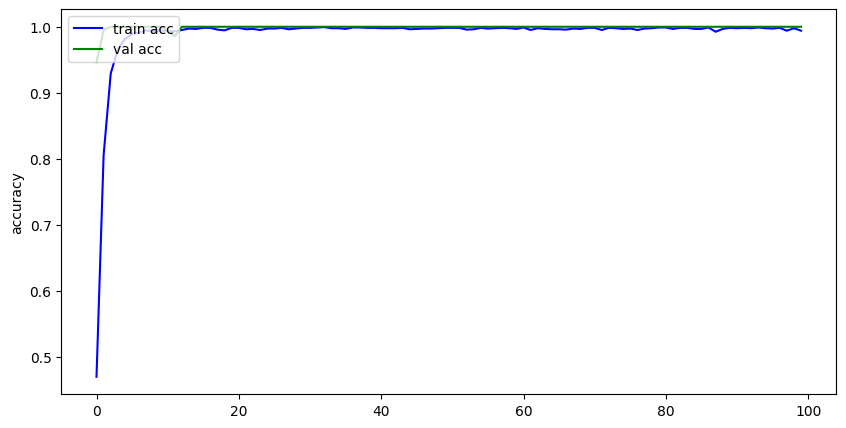

In [54]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10, 5))

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

fig, acc_ax = plt.subplots(figsize=(10, 5))
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()